In [1]:
#os.chdir('/home/lichi/jupiter/imaginarium')
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline

import pandas as pd
import numpy as np
import pickle
import os
from random import sample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('preprocessed_data/words_coco_vectors.pickle', 'rb') as f:
    words_vec = pickle.load( f, encoding='latin1')
with open('preprocessed_data/image_coco_vectors.pickle', 'rb') as f:
    img_vec = pickle.load( f, encoding='latin1')

In [150]:
words_vec_train = words_vec
words_vec_test = words_vec
img_vec_train = img_vec[:150,:]
img_vec_test = img_vec[150:,:]

In [160]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(np.concatenate([words_vec_train, img_vec_train]))

#words_vec_train_pca = pca.transform(words_vec_train)
#img_vec_train_pca = pca.transform(img_vec_train)
#
#words_vec_test_pca = pca.transform(words_vec_test)
#img_vec_test_pca = pca.transform(img_vec_test)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [161]:
words_vec_train_pca = words_vec_train
img_vec_train_pca = img_vec_train

words_vec_test_pca = words_vec_test
img_vec_test_pca = img_vec_test

In [162]:
#from lib.torch_models import ImaginariumModel as ImaginariumModel_lib
from lib.gumbel_softmax import gumbel_softmax

In [163]:
from lib.data_preprocessing import get_training_data as get_training_data_lib

### Делаем данные

In [164]:
# Датасет - подготавливаем наборы из 10 картинок , выбираем из них случайно одну
num_samples = 1000
num_cards = 5
num_words = 998
len_emb = 1024
len_dense = 20

### Делаем модель

In [181]:
model = ImaginariumModel(num_cards, num_words, len_emb, len_dense).to(device)
num_batches = 40
history_loss = []
loss_fn = torch.nn.NLLLoss().to(device)

In [ ]:
accuracy_list = []
for t in range(num_batches):
    # Считаем точность модели на тесте
    X_img_test, y_img_true_test, X_txt_test, X_img_ind_test = get_training_data_lib(
    num_samples, num_cards, num_words, len_emb, img_vec_test_pca, words_vec_test_pca)
    
    y_pred = model(X_img, X_txt, y_img_true)
    y_pred_ind = np.argmax(y_pred.detach().numpy(), axis = 1)
    y_img_true_ind = np.argmax(y_img_true, axis = 1) 
    accuracy = np.mean([x==y for x,y in zip(y_pred_ind, y_img_true_ind)])
    print('accuracy={}'.format(accuracy))
    
    # Тренируем модель
    X_img_train, y_img_true_train, X_txt_train, X_img_ind_train = get_training_data_lib(
    num_samples, num_cards, num_words, len_emb, img_vec_train_pca, words_vec_train_pca)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=1)
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X_img, X_txt, y_img_true).to(device)
    # Compute and print loss
    loss = loss_fn(y_pred, torch.max(y_img_true, 1)[1])
    if t % 1. == 0:
        print(t, loss.item())
    history_loss.append(loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    accuracy_list.append(accuracy)

/home/lichi/venv/python3/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/lichi/venv/python3/lib/python3.5/site-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy=0.261
0 -0.1999499499797821
accuracy=0.325
1 -0.20002111792564392
accuracy=0.398
2 -0.20009596645832062
accuracy=0.491
3 -0.20017877221107483
accuracy=0.546
4 -0.20027275383472443
accuracy=0.613
5 -0.2003965526819229
accuracy=0.613
6 -0.20057718455791473
accuracy=0.555
7 -0.2008415013551712
accuracy=0.469
8 -0.20119954645633698
accuracy=0.42
9 -0.2016281932592392
accuracy=0.402
10 -0.20206966996192932
accuracy=0.42
11 -0.20254471898078918
accuracy=0.446
12 -0.2030981481075287
accuracy=0.45
13 -0.20374935865402222
accuracy=0.476
14 -0.20453906059265137
accuracy=0.492
15 -0.20550532639026642
accuracy=0.505
16 -0.20671136677265167
accuracy=0.522
17 -0.20821231603622437
accuracy=0.539
18 -0.21004846692085266
accuracy=0.553
19 -0.21239686012268066
accuracy=0.575
20 -0.2156793475151062
accuracy=0.599
21 -0.22109273076057434
accuracy=0.425
22 -0.21496310830116272
accuracy=0.263
23 -0.20026986300945282
accuracy=0.282
24 -0.20047172904014587
accuracy=0.314
25 -0.20068727433681488
accur

In [30]:
#accuracy_list_linear = accuracy_list
accuracy_list_combo = accuracy_list

PicklingError: Can't pickle <class '__main__.ImaginariumModel'>: it's not the same object as __main__.ImaginariumModel

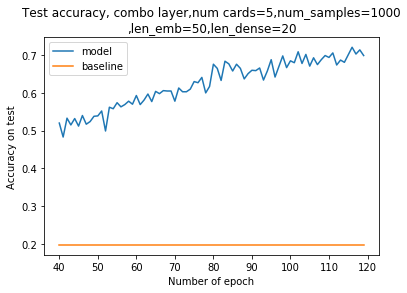

In [46]:
N = 2
mean_acc = accuracy_list_combo
title = 'Test accuracy, combo layer,num cards={0},num_samples={1}\n,len_emb={2},len_dense={3}' .format(
    num_cards, num_samples, len_emb, len_dense)
fig = plt.plot(list(range(40, len(mean_acc)+40)), mean_acc, label = 'model')
plt.plot(list(range(40, len(mean_acc)+40)), [baseline_acc]*80, label = 'baseline')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy on test')
plt.title(title)
plt.legend()
savefig('pictures/%s.png'%title)
torch.save(model, 'models/%s'%title) 


#### Считаем бейзлайн

In [172]:
X_img, y_img_true, X_txt, X_img_ind = get_training_data_lib(
    num_samples, num_cards, num_words, len_emb, img_vec, words_vec)

In [176]:
model_base = ImaginariumModel(num_cards, num_words, len_emb, len_dense, inference = True, categorical = False)

In [177]:
y_pred = model_base(X_img, X_txt, y_img_true)
y_pred_ind = np.argmax(y_pred.detach().numpy(), axis = 1)
y_img_true_ind = np.argmax(y_img_true, axis = 1) #200, 5

/home/lichi/venv/python3/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/lichi/venv/python3/lib/python3.5/site-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [178]:
baseline_acc = np.mean([x==y for x,y in zip(y_pred_ind, y_img_true_ind)])
baseline_acc

0.185

### Сетка

In [171]:
class ImaginariumModel(torch.nn.Module):
    def __init__(self, num_cards, num_words, len_emb, len_dense, inference = False, categorical = False):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ImaginariumModel, self).__init__()
        self.linear10 = torch.nn.Linear(len_emb, len_dense)
        self.linear11 = torch.nn.Linear(len_dense, len_dense)
        self.linear2 = torch.nn.Linear(num_cards, num_cards)
        self.distance0axis = torch.nn.modules.distance.CosineSimilarity(dim = 0)
        self.distance1axis = torch.nn.modules.distance.CosineSimilarity(dim = 1)
        self.distance2axis = torch.nn.modules.distance.CosineSimilarity(dim = 2)
        self.softmax = torch.nn.Softmax()
        self.relu = torch.nn.ReLU()
        self.combination = nn.Sequential(self.linear10,
                                        self.relu,
                                        self.linear11)
        self.inference = inference
        self.categorical = categorical
        
    def distance_mul_sum(self, distance_vec, x_txt_vec):
        return torch.sum(torch.mul(
            distance_vec,x_txt_vec), dim = 0)

    def distance_mul_sum_along_img(self, X_img_elem, X_txt):
        X_img_elem = X_img_elem.repeat(
            num_words,  1)
        distance_vector = ((X_txt - X_img_elem)**2).sum(dim = 0)
        distance_vector_softmax = self.softmax(distance_vector )
        words_final = self.distance_mul_sum(distance_vector_softmax, X_txt)
        return words_final
    
    def distance_word_max_along_img(self, X_img_elem, X_txt):
        X_img_elem = X_img_elem.repeat(
            num_words,  1)
        distance_vector = ((X_txt - X_img_elem)**2).sum(dim = 0)
        num_max = torch.argmax(distance_vector, dim = 0)
        max_len = distance_vector.shape[0]
        distance_vector_cat = torch.cat((torch.zeros(num_max), torch.ones(1), torch.zeros(max_len - num_max-1)))
        words_final = self.distance_mul_sum(distance_vector_cat, X_txt)
        return words_final

    def forward(self, x_img, x_txt, y_img_true):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        if not self.inference:
            x_img_dense = self.combination(x_img)
            x_txt_dense = self.combination(x_txt)
        else:
            x_img_dense = x_img
            x_txt_dense = x_txt
            
        num_hidden_card = torch.argmax(y_img_true, dim=1)
        
        if not self.categorical:
            words_final_dense = torch.stack([self.distance_mul_sum_along_img(
                x_img_dense[i,j,:], x_txt_dense[i,:,:]) for i,j in enumerate(num_hidden_card)])
        else:
            words_final_dense = torch.stack([self.distance_word_max_along_img(
                x_img_dense[i,j,:], x_txt_dense[i,:,:]) for i,j in enumerate(num_hidden_card)])
        
        words_final_dense_repeat = words_final_dense.repeat(num_cards, 1, 1)
        words_final_dense_repeat = words_final_dense_repeat.permute(1,0,2)
        distance = self.distance2axis(words_final_dense_repeat, x_img_dense)
           
        distance_softmax = self.softmax(distance)
        return distance_softmax


### Экспериментируем с матричным умножением

In [ ]:
layer_test = torch.nn.Linear(10, 2)

In [ ]:
X_test = torch.FloatTensor([[range(10)]*5]*7)

In [ ]:
layer_test(X_test[0,0,:]).re

In [ ]:
layer_test(X_test)

### Дебажим

In [ ]:

X_txt_el = X_txt[0,:,:]
X_img_elem = X_img[0,:,0].repeat(
            num_words,  1).permute(1, 0)

In [ ]:
((X_txt_el - X_img_elem)**2).sum(dim = 0)
fun = torch.nn.modules.distance.CosineSimilarity(dim = 0)
fun(X_txt_el, X_img_elem).max()

In [ ]:
#plt.plot(img_vec_pca.sum(axis=0))
plt.plot(img_vec.sum(axis=0))



In [ ]:
for num_comp in range(num_cards):
    plt.plot([X_img[i][:,num_comp].sum() for i in range(num_samples)], label = '{0} component'.format(num_comp))
plt.legend()

### Отрисовываем на графике

In [ ]:
N = 2
mean_loss = np.convolve(np.array(history_loss), np.ones((N,))/N, mode='valid')
#title = 'Model with 2 dense layers and ReLu and inverted 1 dense distances, num cards = %s' % num_cards
title = 'Model with same input, overfitting, num cards = %s' % num_cards
fig = plt.plot(list(range(len(mean_loss))), mean_loss)
plt.xlabel('Number of batch')
plt.ylabel('Smoothed logloss')
plt.title(title)
savefig('pictures/%s.png'%title)
torch.save(ImaginariumModel, 'models/%s'%title) 


### Смотрим, что получилось на выходе

In [ ]:
torch.FloatTensor([[1,2,3], [1,2,3]]).reshape(3,2)

In [ ]:
torch.FloatTensor([[1,2,3], [1,2,3]]).permute(1,0)

###  Описание экспериментов.
 
 Ссылка на скрипт с экспериментами на гитхабе
 https://github.com/Tennessyy/imaginarium/blob/master/network%2Btorch.ipynb
 
 
 У нас  есть множество картинок и множество слов.  Глобальная задача - в игре из как минимум 3 игороков научиться подбирать нетривиальные ассоциации водящего под выбранную картинку, так чтобы оставшиеся 2 игрока в части случаев понимали, а в части случаев не понимали, кому из игроков принадлежит картинка, под которую подобрана ассоциация. В качестве бейзлайна под эту задачу предлагается рассмотреть задачу 2 игроков - 1 игрок загадывает ассоциацию к 1 картинке из k(5 или 10), а 2 игрок по этой ассоциации пытается понять, какую из k картинок выбрал игрок. 
 
В качестве картинок рассматривается коллекция из ~200 изображений из игры "Имаджинариум", в качестве слов ~ 1000 самых популярных слов английского языка. Обучающая выборка гененируется следующим образом - из множества картинок случайно выбираем k картинок, из них случайно одну картинку. Задача сети - по картинке подобрать такое текстовое описание, чтобы сеть догадалась, какая из k картинок была выбрана. Набор из k картинок и всех слов подается в некую сеть (полносязную). Полученные после этого представления идут в  часть сетки, которая считает расстояние между представлением k картинок и всеми словами, пропускает через softmax, усредняя после этого полученные векторы слов. Далее к полученному вектору слов ищется ближайшая из k картинок картинка.
 
 Какие параметры пробовала менять:
 
 1) Менять количество карт на руках у игрока
 
 2) После подсчета финальных расстояний между всеми картами у ведущего игрока и его текстовой ассоциации, обрабатывать его полносвязной сетью
 
 3) Различные конфигурации сетки, которая обрабатывает картинко-текстовове пространство (полносвязная, 2 полносвязные+ relu, полносвязная+relu)
 
 4) Пропускать изначальное пространство кросс-эмбеддингов через PCA, чтобы сократить размерность пространства с 1024 до, например, 100.
 
 5) Вместо softmax при выборе текстовых векторов, ближайших к ставить gumbel softmax
 
 6) Различные метрики расстояния 
 
 
 Текущие успехи(по сравнению с предыдущим):
 
 1) Модель переведена на торч 
 
 2) По модели текут градиенты, на повторяющихся данных удается добиться переобучения :)
 
 3) Попробованы и выписаны разные варианты сети, которые можно быстро запихнуть в другие модели
 
 4) Модель как-то учится
 
 
 Примеры более или менее удачных попыток:
 
 Пример переобучения
 
 
 
 
  Актуальные проблемы:
 
 1) Учится очень медленно
 
 2) Гумбеловский софтмакс не очень помогает
 

 
 
 Планы на ближайшее будущее:
 
 1) Распространить бейзлайн на игру из трех игроков - возможно это поможет с обучением.
 
 2) Сделать как в attention - вместо расстояний подставить dense слои с attention
 
 2) Переписать применение dense слоев более оптимально
 
 3) Провести эксперименты с предложениями вместо слов и другими картинками
 
 4) Влезть в ImageCaptioning

In [ ]:
# Дампим массив, в котором содержатся индексы  топ10,
# близких по mse слов-ассоциаций к картинке для каждой картинки
with open('preprocessed_data/idx_words_array.pickle', 'rb') as f:
    idx_words_array = pickle.load( f)
# Дампим массив, в котором содержатся индексы  топ10,
# близких по mse слов-ассоциаций к картинке для каждого ckjdf
with open('preprocessed_data/idx_images_array.pickle', 'rb') as f:
    idx_images_array = pickle.load( f)
# Дампим массив, в котором содержатся инфа о том,
# в скольки процентах случаев это слово входит в топ-10 ближайших для всех картинок
with open('preprocessed_data/norm_idx_words_array.pickle', 'rb') as f:
    norm_idx_words_array = pickle.load( f, encoding='latin1')
# Дампим массив, в котором содержатся инфа о том,
# в скольки процентах случаев эта картинка входит в топ-10 ближайших для всех слов
with open('preprocessed_data/norm_idx_images_array.pickle', 'rb') as f:
    norm_idx_images_array = pickle.load( f, encoding='latin1')
# Дампим массив, в котором содержатся расстояние до топ k слов 
with open('preprocessed_data/mse_words_top_array.pickle', 'rb') as f:
    mse_words_top_array = pickle.load( f, encoding='latin1')
# Дампим массив, в котором содержатся расстояние до топ k слов 
with open('preprocessed_data/mse_words_top_array.pickle', 'rb') as f:
    mse_words_top_array = pickle.load( f, encoding='latin1')

In [ ]:
# Сэмплируем случайные num_cards векторов
def generate_arrays_from_file(image_vectors, words_vectors,
                              batch_size = 50, num_cards = 10,
                              num_words = 998):
    while 1:
        X_images = []
        y_true_image = []
        for i in range(batch_size):
            img = np.array(sample(range(1,len(image_vectors)), num_cards))
            X_images.append(img)
            true_image = sample(img, 1)
            y_true_image.append(np.array([1 if x==true_image
                                          else 0 for x in X_images[i]]))
        # Эмбеддинги для всех картинок
        X_images = image_vectors[X_images].reshape(num_samples,
                                                   1024, num_cards)
        # Эмбеддинги для правильной картинки, размноженные 10 раз
        t =np.array(X_images)[:,:,np.argmax(y_true_image)]
        X_true_img = np.repeat(t.reshape(t.shape[0],t.shape[1],1),
                               num_words,axis =2).reshape(num_samples,
                                                          num_words, 1024)
        # Эмбеддинги для всех текстов
        X_all_texts = np.repeat(words_vectors.reshape(
            1, num_words, 1024),num_samples, axis = 0 )
        # Решейплю
        X_images = X_images.reshape(batch_size,
                                    num_cards, 1024)
        # Ответы
        y_true_image = np.array(y_true_image).reshape(batch_size,
                                                      1, num_cards)
        yield ([X_images, X_true_img, X_all_texts], y_true_image)
   

### Генератор

In [ ]:
for card in range(num_cards):
            for sample in range(num_samples):
                x_img_dense[sample,:,card] = self.combination(x_img[sample,:,card])
        for sample in range(num_samples):
            for word in range(num_words):
                x_txt_dense[sample,:,word] = self.combination(x_txt[sample,:,word])
            